<a href="https://colab.research.google.com/github/XinZhang0423/machine_learning_tps/blob/main/TP_HumanActivity_Classification_Apprentis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/data/"
os.chdir(path)
!ls

Mounted at /content/drive
 column_2C.dat	 iris.data  'UCI HAR Dataset'


# Human Activities - Classification

Pour ce TP nous allons mettre en pratique plusieurs méthodes de classification supervisée sur des données d'enregistrement d'acceleromètres (de smart-phones).

Les données sources sont disponibles sur [ici](http://bertrand.michel.perso.math.cnrs.fr/Enseignements/Data/UCI-HAR-Dataset.zip), voir aussi la description sur le site de [la plateforme de données UCI](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

"The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. See 'features_info.txt' for more details."

L'objectif de ce TP est de retrouver l'activité à partir de toutes ces descripteurs (features). Notez que dans un contexte plus réaliste il vous faudrait créer par vosu même tous ces features qui décrivent les séries temporelles des accelerations enregistrées.


In [2]:
%matplotlib inline
from pylab import *
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing,model_selection
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Importation des données


Les commandes suivantes permettent de récupérer les données.
Pour simplifier on n'utilise pour le TP que les données du dossier "train".

> Vérifiez que vous comprenez l'ensemble des commandes ci-dessous.

In [3]:
votre_path= "UCI HAR Dataset/"

#### Importation des features

In [4]:
data_path = votre_path + "train/X_train.txt"
activity_features = pd.read_csv(data_path,delim_whitespace=True,
                                header=None)

#### Importation des activités :

In [5]:
data_path = votre_path + "train/y_train.txt"
activity  =    pd.read_csv(data_path,delim_whitespace=True,header=None)
activity  =  activity.values[:,0] -  1 
# la première activité sera 0 (plus pratique en python)
activity_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

La variable à prédire  est la variable d'activité. Il s'agit donc d'un problème de classification (à 6 classes).
Pour cela on dispose des variables du tableau `activity_features`. 
> Combien de variables sont disponibles pour construire le prédicteur de l'activité ?  De combien d'observations dispose-t-on ?

In [6]:
print(f"{activity_features.shape[1]} variables sont disponibles avec {activity_features.shape[0]} observations ")

561 variables sont disponibles avec 7352 observations 


Pour de nombreux méthodes d'appprentissage statistique, il est conseiller de préalablement standardiser les données.

> Effectuer une standardisation des features (activity_features) avec la fonction  [scale()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) de scikit-learn.

In [7]:
#scale()
features_nor =preprocessing.scale(activity_features,axis=0,with_mean=True,with_std=True)  #variable par variable,données standardisées
#StandardScaler().fit_transform()
features_nor1=preprocessing.StandardScaler(copy=False,with_mean=True,with_std=True).fit_transform(activity_features)
print((features_nor==features_nor1).all())

True


#### Importation des sujets :

In [8]:
data_path = votre_path + "train/subject_train.txt"
sujet1 =  pd.read_csv(data_path,delim_whitespace=True,header=None)
sujet =sujet1.values[:,0]

A chaque sujet correspond plusieurs observations.
> Indiquer le nombre d'observations de chaque sujet

In [9]:
print(sujet1.value_counts())

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
dtype: int64


# Problème de classification à deux classes

Dans toute la première partie du TP, on considère un problème de classification à deux classes. 

> Extraire les donnnés pour les activités  'WALKING_DOWNSTAIRS' (activity = 3)  et 'SITTING' (activity =4) uniquement. On appele `features34` et `activity34` les données correspondantes.

In [10]:
n,p = shape(features_nor)
index_act34 = [i for i in range(n) if activity[i]==3 or activity[i]==4] 
activity34 = activity[index_act34]
features34 = features_nor[index_act34,:]
print(shape(features_nor),size(index_act34), shape(features34))

(7352, 561) 2660 (2660, 561)


# Présélection de features  pour réduire la dimension (screening)

Pour diminuer les temps de calul on peut pré-sélectionner les 100 features les plus discriminants via un critère univarié. 

> Utiliser le critère  [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) basé sur la F-value (variance inter / variance intra).

Attention, cette méthode ne garantit en rien que l'on a choisi le "meilleur" groupe de 100 variables pour le problème de classification.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
Selec = SelectKBest(f_classif,k=100)
features34 = Selec.fit_transform(features34,activity34)
shape(features34)

(2660, 100)

# Ajustement et prédiction pour des méthodes classiques de classification 

> Pour chacune des méthodes de classificiation listées ci-dessous, ajuster un predicteur de l'activité en utilisant comme données d'apprentissage la base (features34,activity34) :      
- Classifieur naif bayesien avec la fonction `GaussianNB()`   
- Classifieur des k plus proches voisins avec `neighbors.KNeighborsClassifier()` avec 5 plus proches voisins.  
- Classifieur par régression logistique avec pénalisation ridge, en utilisant la fonction `linear_model.LogisticRegression() `. Indiquer la pénalité "l2" dans les arguments de la fonction et choisir le solveur "saga" (voir la doc de la fonction).


Une présentation de chacune des ces fonctions est disponible sur cette [page](http://scikit-learn.org/stable/user_guide.html).
</p>

In [12]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
gnb.fit(features34,activity34 )


from sklearn import neighbors
nn = neighbors.KNeighborsClassifier(n_neighbors=5)
nn.fit(features34,activity34)


from sklearn import linear_model
logit =linear_model.LogisticRegression(solver='saga').fit(features34,activity34)

Pour chacune de ces méthodes, on peut faire une prédiction grâce à la méthode `predict()`. par exemple pour le classifieur naif bayesien : 

In [13]:
feat_pred_gnb = gnb.predict(features34)
print(feat_pred_gnb)

[3 3 4 ... 3 3 3]


> Faire de même une prédiction pour le classifieur des plus proches voisins et pour la régression logistique. 

In [14]:
feat_pred_nn = nn.predict(features34)
print(feat_pred_nn)

[4 4 4 ... 3 3 3]


In [15]:
feat_pred_logit = logit.predict(features34)
print(feat_pred_logit)

[4 4 4 ... 3 3 3]


> Ces prédictions sont-elles cohérentes entre elles ?

In [16]:
print((feat_pred_gnb==feat_pred_nn).all())
print((feat_pred_gnb==feat_pred_logit).all())
print((feat_pred_logit==feat_pred_nn).all())

False
False
False


> Pour chaque prédicteur :
> - Calculer le taux d'erreur "à la main" en comparant les observations et les prédictions.
> - Calculer le taux de bon classement avec la méthode `score()` (disponible pour tout predicteur)

In [17]:
error_gnb=((feat_pred_gnb-activity34)**2).sum()/activity34.size
error_nn=((feat_pred_nn-activity34)**2).sum()/activity34.size
error_logit=((feat_pred_logit-activity34)**2).sum()/activity34.size
print(f" les taux d'erreur : {error_gnb = :.2%}, {error_nn = :.2%} et {error_logit = :.2%}")

 les taux d'erreur : error_gnb = 19.44%, error_nn = 3.91% et error_logit = 4.10%


In [18]:
score_gnb=gnb.score(features34,activity34)
score_nn=nn.score(features34,activity34)
score_logit=logit.score(features34,activity34)
print(f" les taux de bon classement : {score_gnb = :.2%}, {score_nn = :.2%} et  {score_logit = :.2%}")

 les taux de bon classement : score_gnb = 80.56%, score_nn = 96.09% et  score_logit = 95.90%


Evidemment ce n'est pas pas la bonne façon d'estimer le risque de l'estimateur : estimer de l'erreur de généralisation en évaluant les erreurs sur l'échantillon qui a déjà servi à ajuster le prédicteur conduit la plupart du temps à une estimation trop optimiste.

# Evaluation de l'erreur par découpage train / test

Nous allons maintenant évaluer l'erreur de généralisation en conservant une partie de l'échantillon pour évaluer les erreurs du prédicteur ajusté. Pour cela on découpe aléatoirement l'échantillon initial en deux parties :  

- l'ensemble d'apprentissage : utilisé pour ajuster les prédicteurs ;
- l'ensemble de test (ou de validation) : utilisé pour évaluer les performances des prédicteurs.

> Utiliser la fonction <code>train_test_split</code> du module [<code>model_selection</code>](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) pour construire un échantillon d'apprentissage de taille 60% (et donc 40% réservées aux données de test)

In [19]:
from sklearn import model_selection
features_train, features_test, activity_train, activity_test =model_selection.train_test_split(features34,activity34,train_size=0.6,shuffle=True)
print(len(activity_train)/ float(len(activity34)))
print(len(activity_test)/ float(len(activity34)))
print(shape(features_test))

0.6
0.4
(1064, 100)


> Evaluer le risque d'un classifieur par plus proches voisins (knn) avec 5 voisins sur ce découpage des données : ajuster sur les données d'apprentissage et évaluer les erreurs sur le test.  
>
> Vérifier que l'estimation de l'erreur ainsi obtenue est plus élevée que l'estimation obtenue précédemment, en ajustant et évaluant l'erreur sur le même échantillon (échantillon complet, sans découpage)

In [20]:
nn.fit(features_train,activity_train)
score_nn_decoupage=nn.score(features_test,activity_test)
print(f"{1 - score_nn_decoupage = :.2%} , {1 - score_nn = :.2%}")

1 - score_nn_decoupage = 8.36% , 1 - score_nn = 3.91%


> Reproduire la procédure 100 fois et dresser le boxplot de l'estimation de l'erreur sur ces 100 runs.

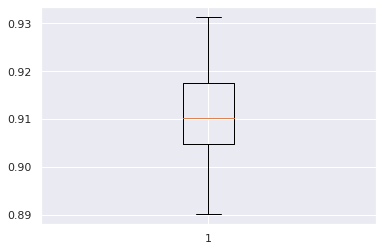

In [21]:
score_train_test = [] # pour stockage des scores
sns.set()
nn_train_test = neighbors.KNeighborsClassifier(n_neighbors=5)
for simu in range(100) :
    features_train, features_test, activity_train, activity_test = model_selection.train_test_split(features34,activity34,train_size=0.6,shuffle=True)
    nn_train_test.fit(features_train,activity_train)
    score_train_test.append(nn_train_test.score(features_test,activity_test))
    
B = plt.boxplot(score_train_test)

> Tracer la courbe d'erreur du classifieur par plus proches voisins en fonction du nombre de voisins utilisés (de 1 à 15), en utilisant cette méthode de découpage train / test répétée 20 fois.

In [22]:
score_train_test = [[] for i in range(1,16)] # pour stockage des scores
for k in range(1,16):
    nn_train_test = neighbors.KNeighborsClassifier(n_neighbors=k)
    for simu in range(20):
        features_train, features_test, activity_train, activity_test = model_selection.train_test_split(features34,activity34,train_size=0.6,shuffle=True)
        nn_train_test.fit(features_train,activity_train)
        score_train_test[k-1].append(nn_train_test.score(features_test,activity_test))

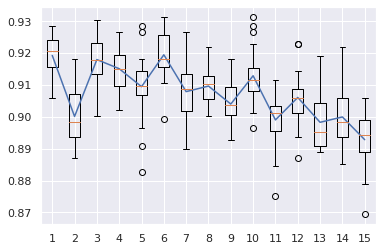

In [23]:
score_train_test=np.array(score_train_test).T
plt.boxplot(score_train_test)
plt.plot(range(1,16),score_train_test.mean(axis=0));

En réalité, si l'on désire une estimation du modèle sélectionné ainsi, il faut découper l'échantillon disponible non pas en deux mais en trois parties :
- l'ensemble d'apprentissage : utilisé pour construire des modèles ;
- l'ensemble de validation : utilisé pour choisir un modèle ;
- l'ensemble de test : utilisé pour évaluer les performances du modèle
  finalement choisi.
  
Ceci est notamment important lorsque l'on souhaite comparer deux méthodes qui ont toutes les deux fait intervenir un réglage de paramètres (ici le nombre de voisins).

> **Question bonus** (finir le tp avant de répondre à cette question) : Mettre en oeuvre cette méthode pour estimer l'erreur de généralisation du prédicteur knn pour lequel le nombre de voisins est choisi via l'échantillon de validation.

In [24]:
# méthode1 non-croisée
#découpage train/validation/test
features_tv, features_test, activity_tv, activity_test = model_selection.train_test_split(features34,activity34,train_size=0.6,shuffle=True)
features_t,features_v,activity_t,activity_v=model_selection.train_test_split(features_tv,activity_tv,train_size=0.3,shuffle=True)

scores=[]
for k in range(1,20):
    nn_t = neighbors.KNeighborsClassifier(n_neighbors=k)
    nn_t.fit(features_t,activity_t)
    scores.append(nn_t.score(features_v,activity_v))

nn_final=neighbors.KNeighborsClassifier(n_neighbors=np.array(scores).argmax())
taux_bon=nn_final.fit(features_t,activity_t).score(features_test,activity_test)

print(f'{taux_bon = :.2%}')

taux_bon = 85.24%


In [25]:
# méthode2 validation croisée - GridSearchCV
from sklearn.model_selection import GridSearchCV
features_tv, features_test, activity_tv, activity_test = model_selection.train_test_split(features34,activity34,train_size=0.6,shuffle=True)

tuned_param={'n_neighbors':range(1,20)}
mykfold=model_selection.KFold(n_splits=10,shuffle=True)
nnGrid=GridSearchCV(neighbors.KNeighborsClassifier(),tuned_param,cv=mykfold,n_jobs=5)
nnGrid.fit(features_tv,activity_tv)
n_neighbors=nnGrid.best_params_['n_neighbors']
print(f'{n_neighbors = : d}')

nn_final=neighbors.KNeighborsClassifier(**nnGrid.best_params_)
taux_bon=nn_final.fit(features_tv,activity_tv).score(features_test,activity_test)
print(f'{taux_bon = :.2%}')

n_neighbors =  1
taux_bon = 91.35%


# Estimation du risque par validation croisée 

On présente ci-dessous la méthode de validation croisée de type **k-fold**.

L'idée principale est de faire jouer à chaque observation à la fois le rôle de donnée d'apprentissage et celui de donnée de validation. 

Le principe consiste à partitionner aléatoirement les données $D=(\mathbf{x}_i,y_i)_{1\leq i\leq N} $ 
en $K$ blocs disjoints de tailles comparables :
$D^1,\ldots,D^K$. On prend généralement $K=5$ ou $10$. La méthode du **leave-one-out (Loo)** correspond au choix $K=N$. 

On estime alors la qualité d'un predicteur $\hat f$ de la
façon suivante :
- pour tout $k \in \{1,\dots, K\}$, on construit un predicteur $\hat f^k$ (du même type que $\hat f$) sur l'ensemble d'apprentissage $D^{-k} := D\setminus D^k$ ;
- on estime le risque du prédicteur $\hat f$ par   
$$
\frac{1}{N}\sum_{k=1}^K\sum_{\mathbf{x}_i\in D^k} \ell(\hat f^k(\mathbf{x}_i),y_i),
$$
où $\ell$ est la perte utilisée.

On construit donc autant de prédicteurs qu'il y a de blocs dans
l'ensemble d'apprentissage. Chaque prédicteur est évalué sur les éléments du
bloc qui n'a pas été utilisé pour l'apprentissage (et qui joue donc le rôle d'
ensemble de validation). 

Lorsque l'on souhaite régler un paramètre en utilisant la validation croisée, par exemple le nombre de voisins $k$ pour knn, on procède comme suit :
- on évalue les performances des prédicteurs par validation croisée comme expliqué ci-dessus ;
- on détermine la valeur optimale du paramètre ;
- on construit finalement un predicteur pour le paramètre sélectionné, en utilisant comme base d'apprentissage toutes les données.


**Comparaison entre LOO et methodes k folds, quelques repères :** 
- LOO a un coût computationnel plus élevé que les méthodes k-fold pour k petit (pour k = 5 ou 10 par exemple)
- L'estimation de l'erreur fournie par LOO a généralement une variance plus élevée que celles obtenues par un k-fold pour k petit.
- En revanche, si l'erreur de classification décroit très rapidement avec $n$, les méthodes k-fold avec k petit peuvent surestimer significativement l'erreur de généralisation.
- En général, il est souvent recommandé d'utiliser les méthodes k-fold avec k = 5 ou 10.

L'ensemble des méthodes de validation croisée disponibles sous `sklearn` sont disponibles dans le module [<code>model_selection</code>](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection). Voir aussi le [guide](https://scikit-learn.org/stable/modules/cross_validation.html#).

##  Estimation de l'erreur par 10-fold :

In [26]:
nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = 10)
scores = model_selection.cross_val_score(nn_val_croisee, features34, activity34, cv=10)
print(scores)
print(f'{mean(scores) = : .2%}')

[0.90601504 0.83458647 0.85338346 0.81578947 0.87593985 0.80451128
 0.91353383 0.95864662 0.84586466 0.88345865]
mean(scores) =  86.92%


Attention cependant, avec cette méthode, la fonction `cross_val_score` ne permute pas préalablement les données avant de définir les blocs. Voir cette [note](https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling) dans la doc de sklearn.

> Modifier la procédure pour que les données soient bien initiallement permutées. On utilise pour cela un "iterateur" de validation croisée, que l'on définit ici avec la fonction `KFold`, et que l'on fournit en argument de la fonction `cross_val_score`.

In [27]:
my_kfold = model_selection.KFold(n_splits=10,shuffle=True)

nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = 10)

scores = model_selection.cross_val_score(estimator=nn_val_croisee,
                        X=features34,
                        y=activity34,
                        cv=my_kfold,
                        n_jobs=-1) # permet de répartir les calculs sur plusieurs coeurs
print(f'{mean(scores) = : .2%}')

mean(scores) =  92.67%


##  Estimation de l'erreur par Loo


> Utiliser la fonction <code>LeaveOneOut</code> de `model_selection` pour évaluer l'erreur du classifieur de plus proches voisin (pour 10 voisins).




In [28]:
loo=model_selection.LeaveOneOut()
scores_loo=model_selection.cross_val_score(estimator=nn_val_croisee,
                        X=features34,
                        y=activity34,
                        cv=loo)
print(f"{mean(scores_loo) = :.2%}")

mean(scores_loo) = 92.78%


> La question de la permutation aléatoire initiale des données se pose-t-elle ici aussi ?

Non, puisque l'on estime le risque du prédicteur par la moyenne des pertes sur chaque observation. 

## Sélection du nombre de plus proches voisins par validation croisée 10 fold

> Selectionner un nombre de voisins pour le classifieur de plus proches voisins par validation croisée 10 fold.

In [29]:
scores_k=[]
for k in range(1,18):
    my_kfold = model_selection.KFold(n_splits=10,shuffle=True)
    nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = 10)
    scores = model_selection.cross_val_score(estimator=nn_val_croisee,
                            X=features34,
                            y=activity34,
                            cv=my_kfold,
                            n_jobs=5) 
    scores_k.append(mean(scores))
print(f"k = {np.array(scores_k).argmax()+1}")

k = 14


## La fonction GridSearchCV

En apprentissage statistique, on a très souvent recours à la validation croisée pour régler des paramètres de la méthode utilisée. La fonction [gridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) permet d'effectuer cette tâche de façon simple, en répartissant éventuellement les calculs sur plusieurs coeurs (voir plus bas).

In [30]:
from sklearn.model_selection import GridSearchCV
from time import time

# la grille de parametres a regler sont definis dans un dictionnaire (dict)
tuned_parameters = {'n_neighbors': range(2,20)}
start = time()

my_kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)
nnGrid = GridSearchCV(neighbors.KNeighborsClassifier(),
                      tuned_parameters,
                      cv=my_kfold)
nnGrid.fit(features34, activity34)
print(f"{time() - start:.4f} sec")

# le meilleur modele 
print(nnGrid.best_params_)

4.4963 sec
{'n_neighbors': 3}


> Si votre machine le permet, utiliser maintenant plusieurs coeurs (argument "n_jobs= ") et comparer les temps de calcul.

In [31]:
tuned_parameters = {'n_neighbors': range(2,20)}
start = time()

my_kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)
nnGrid = GridSearchCV(neighbors.KNeighborsClassifier(),
                      tuned_parameters,
                      cv=my_kfold,
                     n_jobs=-1)
nnGrid.fit(features34, activity34)
print(f"{time() - start:.4f} sec")
# le meilleur modele 
print(nnGrid.best_params_)

3.0128 sec
{'n_neighbors': 3}


# Classification multiclasses 

Pour réduire les temps de calcul (il s'agit d'un TP...) nous appliquons la même stratégie de présélection de features que nous avons utilisé pour la classification binaire.

## Présélection de features

Pour réduire les temps de calcul (il s'agit d'un TP...) nous appliquons la même stratégie de présélection de features que pour le cas à deux classes :

In [32]:
Selec = SelectKBest(f_classif, k=100)
features_all_activities = Selec.fit_transform(activity_features, activity)
shape(features_all_activities)

(7352, 100)

#### Classifieur naif bayesien multiclasses

In [33]:
gnb = GaussianNB()
scores  = model_selection.cross_val_score(gnb, features_all_activities, activity, cv=my_kfold)
print(scores)
print(mean(scores))

[0.77581522 0.78668478 0.78367347 0.76054422 0.75646259 0.79319728
 0.76598639 0.80680272 0.79319728 0.76326531]
0.778562925170068


#### Classifieur des k plus proches voisins multiclasses

In [34]:
nn = neighbors.KNeighborsClassifier(n_neighbors = 10)
scores  = model_selection.cross_val_score(nn, features_all_activities, activity, cv=my_kfold)
print(scores)
print(mean(scores))

[0.94021739 0.95108696 0.95646259 0.94013605 0.9414966  0.9414966
 0.94285714 0.94965986 0.93877551 0.94285714]
0.9445045844424726


> Effectuer un découpage apprentissage / test des données (avec toutes les classes).
> Utiliser la fonction `GridSearchCV` sur l'échantillon d'apprentissage pour choisir le nombre de voisins pour l'estimateur knn. Dresser et afficher la matrice de confusion sur les données de test, voir [ici](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) et [ici](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

In [35]:
features_train, features_test, activity_train, activity_test =model_selection.train_test_split(features_all_activities,activity,train_size=0.6,shuffle=True)
tuned_parameters = {'n_neighbors': range(2,20)}

my_kfold = model_selection.KFold(n_splits=10, shuffle=True)
nnGrid = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),
                      tuned_parameters,
                      cv=my_kfold ,
                     n_jobs=-1)
nnGrid.fit(features_train,activity_train)
print(nnGrid.best_params_)

{'n_neighbors': 3}


In [36]:
knn=neighbors.KNeighborsClassifier(**nnGrid.best_params_).fit(features_train,activity_train)

In [37]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_mat=confusion_matrix(activity_test,knn.predict(features_test),labels=knn.classes_)

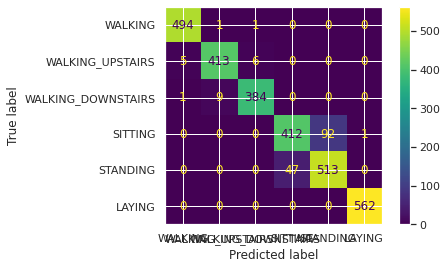

In [38]:
disp=ConfusionMatrixDisplay(conf_mat,display_labels=activity_names)
disp.plot()
plt.show()

# Regression logistique Lasso

> Ajuster et évaluer un modèle logistique Lasso sur les données avec la fonction [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

In [39]:
from sklearn import linear_model
logit =linear_model.LogisticRegressionCV(penalty='l2',max_iter=100, random_state=0,solver='saga',n_jobs=-1).fit(features_train,activity_train)

In [40]:
conf_mat_logit=confusion_matrix(activity_test,logit.predict(features_test),labels=logit.classes_)
print(conf_mat_logit)

[[484  10   2   0   0   0]
 [  6 411   6   0   1   0]
 [  4   6 384   0   0   0]
 [  0   0   0 442  63   0]
 [  0   0   0  59 501   0]
 [  0   0   0   0   0 562]]


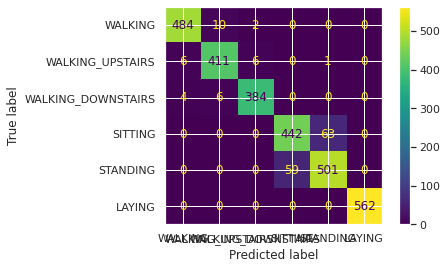

In [41]:
disp=ConfusionMatrixDisplay(conf_mat_logit,display_labels=activity_names)
disp.plot()
plt.show()

# Analyse en composantes principales sur la tableau des features.

L'analyse en composantes principales est une méthode de réduction de dimension, de visualisation et de compression de données. Elle consiste à déterminer le sous-espace vectoriel de dimension $q$ qui approche au mieux possible un nuage de points dans $\mathbb R^d$ (au sens de la projection euclidienne sur cet espace).

Les directions du sous-espace vectoriel approximant peuvent être vues comme de nouvelles variables, qui s'éxpriment comme des combinaisons linéaires des variables initiales. Par ailleurs, ces nouvelles variables, appelées **composantes principales**, sont dirigées selon les premières directions propres de la matrice de covariance empirique des données.

On représente alors les données dans le nouveau système de variables issu de l'ACP.  

![analyse en composantes principales](http://www.nlpca.org/fig_pca_principal_component_analysis.png)

Un descriptif de la fonction `sklearn.decomposition.PCA()` de la librairie scikit-learn est disponible [ici](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

> Tracer le nuage des deux premières composantes de l'ACP en distinguant les 5 activités. 
> Dans son écriture, le problème de l'ACP ignore la classification en classes d'activité. Les classes d'activités sur ces deux premières composantes sont elles bien séparées ? 
> En particulier, vérifier graphiquement que les classes 3 et 4 (pour lesquelles nous avons proposé des classifieurs plus haut) ne sont pas facilement séparées par les deux premiers axes de l'APC. 

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
print(pca)

PCA(n_components=5)


In [43]:
pca.fit(features_nor)    # ajuster la PCA sur les données features_nor
features_nor_pac=pca.transform(features_nor)# transformer  (prediction) les données features_nor pour le modele PCA

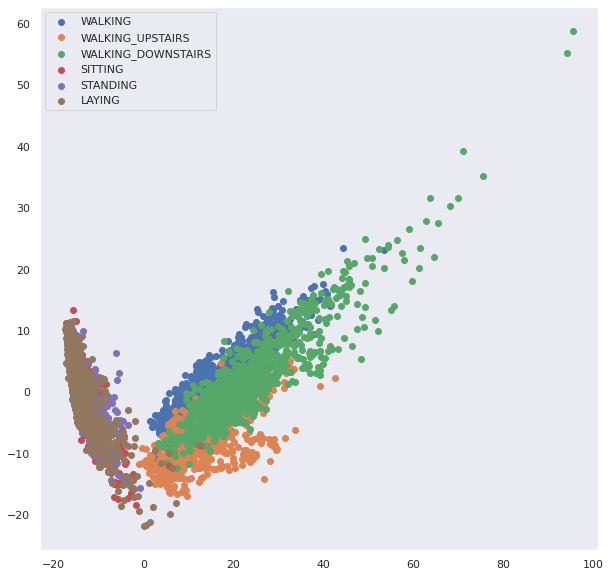

In [44]:
ACP0 = np.array(features_nor_pac)[:,0] # extraction premiere composante
ACP1 = np.array(features_nor_pac)[:,1] # extraction deuxieme composante

plt.figure(figsize=(10, 10))
for c, i, act in zip("rgbycm", range(0,6),range(0,6)):
    plt.scatter(ACP0[activity==act],ACP1[activity==act],cmap=c,label=activity_names[i])
# iterer sur les activités et utiliser un zip pour
# faciliter la representation graphique des objets 
# sur lesquels on itere
plt.grid()
plt.legend();

Bonus: 
- utiliser umap ou tsne à la place de l'ACP
- effectuer un clustering des données projetées sur les 2 premiers axes de l'ACP kmeans

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.003s...
[t-SNE] Computed neighbors for 7352 samples in 1.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 4.509035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.858093
[t-SNE] KL divergence after 1000 iterations: 1.521822


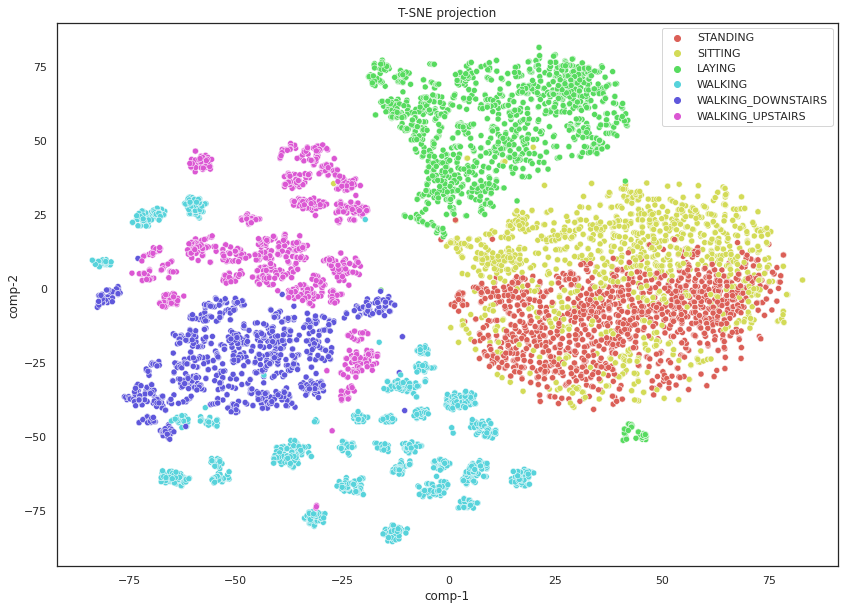

In [45]:
#visualisation avec t-sne
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features_nor)
df = pd.DataFrame()
df["y"] = np.array(activity_names)[activity]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df).set(title="T-SNE projection");

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6feb1e85a5be764c04747a58af04c64853dabce05e27ef7343ac6d9d1b231bcd
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=0f586141a2b3404317fb75d425ba337509b42771c00b7c2d62b26c4511c803fd
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


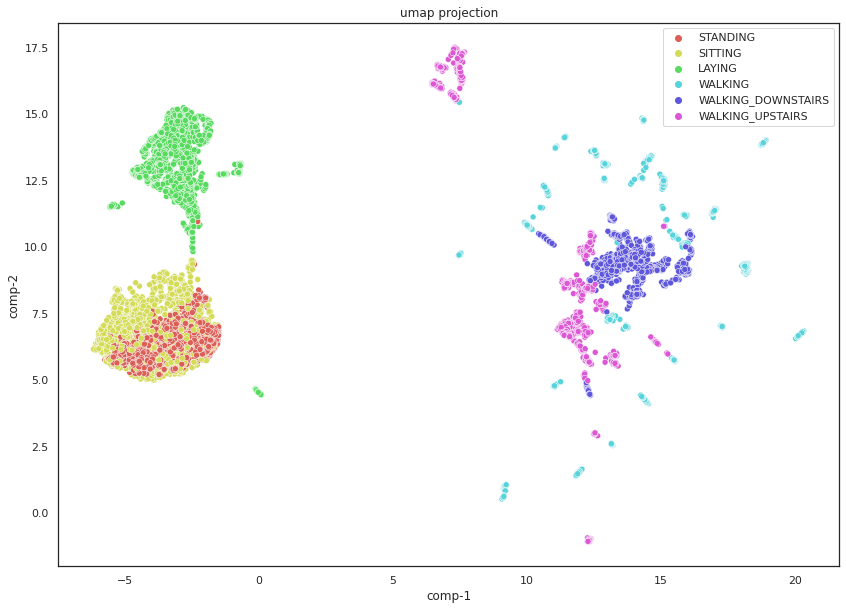

In [46]:
#visualisation avec umap
! pip3 install umap-learn
import umap
umap_reducer = umap.UMAP()
z= umap_reducer.fit_transform(features_nor)
df = pd.DataFrame()
df["y"] = np.array(activity_names)[activity]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df).set(title="umap projection");

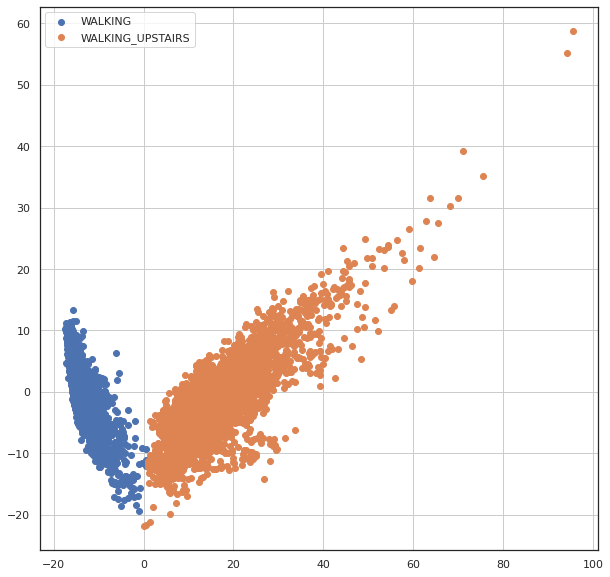

In [47]:
from sklearn.cluster import KMeans
k=2
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features_nor_pac[:,:2])

plt.figure(figsize=(10, 10))
for c, i, act in zip("rg", range(k),range(k)):
    plt.scatter(ACP0[kmeans.labels_==act],ACP1[kmeans.labels_==act],cmap=c,label=activity_names[i])
plt.grid()
plt.legend();